## Machine Learning Basics

The basic example of (practical) Machine Learning is joining my collection of "hello worlds".  Rest assured, it isn't the house price prediction example, however, it is the ultra-exploited Titanic survivors Kaggle dataset. The purpose of this notebook it to have a quick look-up guide of functions regularly used in the Machine Learning pipeline. We will do Exploratory Data Analysis, Feature Engineering, Feature and Model Selection[,](https://en.oxforddictionaries.com/explore/what-is-the-oxford-comma/) and Hyperparameter Tuning on the [Titanic Dataset](https://www.kaggle.com/c/titanic) with the goal of predicting whether a passenger would survive nor not, based on features such as their gender and ticket fare.

In [5]:
import pandas as pd

In [6]:
train = pd.read_csv("titanic_data/train.csv")
holdout = pd.read_csv("titanic_data/test.csv")

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [8]:
def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df,"Age_categories")
    df = create_dummies(df, "Fare_categories")
    df = create_dummies(df,"Title")
    df = create_dummies(df,"Cabin_type")
    df = create_dummies(df,"Sex")
    return df

In [9]:
train = pre_process(train)
holdout = pre_process(holdout)

## Data Exploration

In [10]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [11]:
train[["SibSp","Parch"]].describe()

,SibSp,Parch
count,891.000000,891.000000
mean,0.523008,0.381594
std,1.102743,0.806057
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,8.000000,6.000000


In [12]:
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [13]:
train.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [22]:
np.round(pd.pivot_table(train, values='Survived', index='SibSp',  columns='Parch'),2)
#.apply(round,args=[2])

Parch,0,1,2,3,4,5,6
SibSp,,,,,,,
0,0.30,0.66,0.72,1.00,0.0,0.00,NaN
1,0.52,0.60,0.63,0.33,0.0,0.33,0.0
2,0.25,0.86,0.50,1.00,NaN,NaN,NaN
3,1.00,0.00,0.29,NaN,NaN,NaN,NaN
4,NaN,0.00,0.33,NaN,NaN,NaN,NaN
5,NaN,NaN,0.00,NaN,NaN,NaN,NaN
8,NaN,NaN,0.00,NaN,NaN,NaN,NaN


In [15]:
train["family_size"] = train.SibSp + train.Parch

In [23]:
train.pivot_table(index='family_size',values="Survived")

,Survived
family_size,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


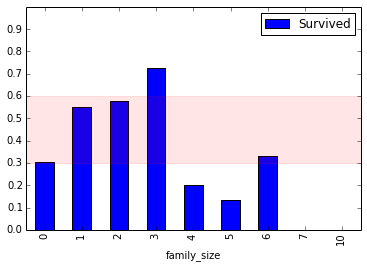

In [24]:
pivot = train.pivot_table(index="family_size",values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.axhspan(.3, .6, alpha=0.1, color='red')
plt.show()

The distribution of values in both columns is skewed right, with the majority of values being zero.

You can sum these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity tapers off less rapidly as the values increase.

Looking at the survival rates of the the combined family members, you can see that few of the over 500 passengers with no family members survived, while greater numbers of passengers with family members survived.

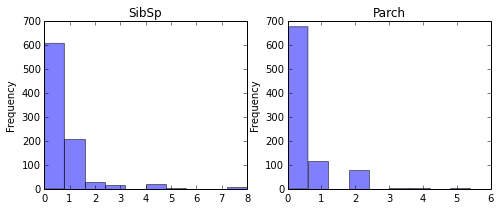

In [25]:
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1,2,1)
ax.set_title("SibSp")
train.SibSp.plot.hist(alpha=0.5)

ax = fig.add_subplot(1,2,2)
ax.set_title("Parch")
train.Parch.plot.hist(alpha=0.5)

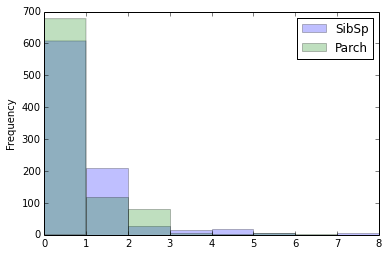

In [26]:
train[["SibSp","Parch"]].plot.hist(alpha= 0.25,bins=8)

## Feature Engineering

we can come up with an idea for a new feature - was the passenger alone. This will be a binary column containing the value:

1 if the passenger has zero family members onboard
0 if the passenger has one or more family members onboard

In [27]:
def is_alone(df):
    df["isalone"] = df["family_size"]  > 1
    return df

In [28]:
train = is_alone(train)
holdout["family_size"] = holdout.SibSp + holdout.Parch
holdout = is_alone(holdout)

## Feature Selection

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    X = df.drop(["Survived","PassengerId"],axis=1)
    y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(X,y)
    
    best_columns = list(X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

cols = select_features(train)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Teenager', 'Age_categories_Young Adult', 'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12', 'Fare_categories_12-50', 'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'family_size']



## Model Selection / Hyperparameter Tuning

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [31]:
def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train,cols)

LogisticRegression
------------------
Best Score: 0.821548821549
Best Parameters: {'solver': 'newton-cg'}

KNeighborsClassifier
--------------------
Best Score: 0.776655443322
Best Parameters: {'n_neighbors': 19, 'weights': 'distance', 'algorithm': 'brute', 'p': 1}

RandomForestClassifier
----------------------
Best Score: 0.846240179574
Best Parameters: {'min_samples_leaf': 1, 'n_estimators': 9, 'min_samples_split': 2, 'criterion': 'gini', 'max_features': 'log2', 'max_depth': 10}

